In [1]:
!pip install torch==2.0.0
!pip install torchview==0.2.6
!pip install underthesea==1.3.4
!pip install kagglehub
!pip install -U scikit-learn
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.0 MB/s eta 0:00:0000:0100:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 107.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 43.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 32.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 17.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━

## Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from torchview import draw_graph
from underthesea import word_tokenize
from tqdm import tqdm
import kagglehub
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(rc={'figure.figsize': (12,8)})
sns.set(rc={'figure.dpi': 100})
sns.set(style='white', palette='muted', font_scale=1.2)

np.random.seed(42)
torch.manual_seed(42)

In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [5]:
# === Download dataset ===
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tuannguyenvananh/vietnamese-text-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vietnamese-text-classification-dataset


In [9]:
data = pd.read_csv('/kaggle/input/vietnamese-text-classification-dataset/train.csv')
data.info()
data.columns = ['labels', 'text']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   0                       3039 non-null   int64 
 1   máy dùng hay bị đơ máy  3039 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.6+ KB


In [7]:
data.head()

,labels,text
0,0,chỉ có dây cáp nguồn không có adapter sao sử d...
1,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
2,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
3,2,Tuyệt vời. Hàng FPT cửa hàng
4,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...


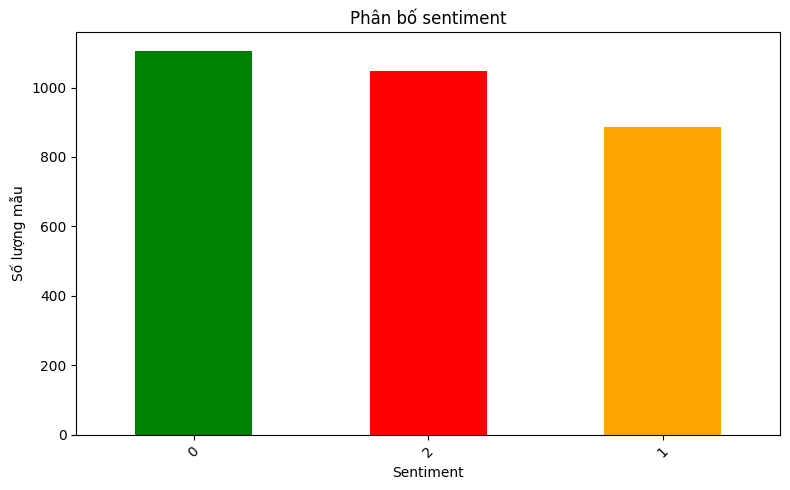


Class distribution:
labels
0    1104
2    1048
1     887
Name: count, dtype: int64

Total samples: 3039


In [10]:
# Display data distribution 
plt.figure(figsize=(8,5))
data["labels"].value_counts().plot(kind="bar", color=["green","red","orange"])
plt.title("Phân bố sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng mẫu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nClass distribution:")
print(data['labels'].value_counts())
print(f"\nTotal samples: {len(data)}")

## Text Preprocessing Pipeline

In [132]:
# Vietnamese text preprocessing (from week3-mlfornlp)
def clean_text_vi(text: str) -> str:
    """ Lowercase, remove URLs, tokenize Vietnamese words, strip punctuation; 
        return a clean string."""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    
    try:
        tokens = word_tokenize(text)   
        out = []
        for tok in tokens:
            for sub in tok.split():  
                if sub not in string.punctuation and len(sub) > 1:
                    out.append(sub)
        return " ".join(out)
    except:
        # Fallback if underthesea fails
        text = re.sub(r'[^\w\sàáảãạăắằẳẵặâấầẩẫậèéẻẽẹêếềểễệìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđ]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# Vietnamese tokenizer for TF-IDF
def uts_tokenize(s: str):
    """Vietnamese tokenizer using underthesea"""
    try:
        return word_tokenize(s, format="text").split()
    except:
        return s.split()

print("Text preprocessing functions defined!")

Text preprocessing functions defined!


In [173]:
# Preprocess data and create label mapping using TF-IDF
print("Preprocessing texts with TF-IDF...")

# Clean texts
texts = data['text'].astype(str).tolist()
cleaned_texts = [clean_text_vi(text) for text in tqdm(texts, desc="Cleaning texts")]

labels = data['labels'].tolist()  

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    preprocessor=clean_text_vi,
    tokenizer=uts_tokenize,
    ngram_range=(1, 3),  # Use unigrams and bigrams
    min_df=3,           # Minimum document frequency
    max_df=0.7,         # Maximum document frequency
    max_features=5000   # Maximum number of features
)

# Fit and transform texts to TF-IDF vectors
print("Fitting TF-IDF vectorizer...")
tfidf_vectors = tfidf_vectorizer.fit_transform(texts)
print(f"TF-IDF shape: {tfidf_vectors.shape}")

# Convert sparse matrix to dense array for PyTorch
tfidf_dense = tfidf_vectors.toarray()
print(f"Dense TF-IDF shape: {tfidf_dense.shape}")

# Get vocabulary info
vocab_size = len(tfidf_vectorizer.vocabulary_)
print(f"Vocabulary size: {vocab_size}")

# Show text statistics
text_lengths = [len(clean_text_vi(text).split()) for text in texts]
print(f"\nText length statistics:")
print(f"Average length: {np.mean(text_lengths):.1f}")
print(f"Max length: {np.max(text_lengths)}")
print(f"90th percentile: {np.percentile(text_lengths, 90):.1f}")

Preprocessing texts with TF-IDF...


Cleaning texts: 100%|██████████| 3039/3039 [00:00<00:00, 49788.25it/s]

Fitting TF-IDF vectorizer...



/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF shape: (3039, 5000)
Dense TF-IDF shape: (3039, 5000)
Vocabulary size: 5000

Text length statistics:
Average length: 30.2
Max length: 366
90th percentile: 60.0


## Data Creation

In [174]:
# Create PyTorch dataset for TF-IDF vectors (similar to samples.ipynb pattern)
class SentimentDataset(Dataset):
    def __init__(self, tfidf_vectors: np.ndarray, labels: List[int]):
        self.vectors = torch.tensor(tfidf_vectors, dtype=torch.float32)  # Use float32 for TF-IDF
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.vectors)
    
    def __getitem__(self, idx):
        return self.vectors[idx], self.labels[idx]

# Train/test split (from samples.ipynb pattern)
train_vectors, test_vectors, train_labels, test_labels = train_test_split(
    tfidf_dense, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train set: {train_vectors.shape[0]} samples")
print(f"Test set: {test_vectors.shape[0]} samples")

# Create datasets
train_dataset = SentimentDataset(train_vectors, train_labels)
test_dataset = SentimentDataset(test_vectors, test_labels)

# Create data loaders
batch_size = 32  # Can use larger batch size with TF-IDF
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")

print(f"Train vectors shape: {train_vectors.shape}")
print(f"Train labels shape: {len(train_labels)}")
print(f"Test vectors shape: {test_vectors.shape}")
print(f"Test labels shape: {len(test_labels)}")

Train set: 2431 samples
Test set: 608 samples
Train batches: 76
Test batches: 19
Batch size: 32
Train vectors shape: (2431, 5000)
Train labels shape: 2431
Test vectors shape: (608, 5000)
Test labels shape: 608


## Neural Network Model

In [185]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        
        self.linear_layer_1 = nn.Linear(n_features, 256)    # First hidden layer
        self.linear_layer_2 = nn.Linear(256, 128)           # Second hidden layer  
        self.linear_layer_3 = nn.Linear(128, n_classes)     # Output layer
        
        # Add dropout for regularization
        self.dropout1 = nn.Dropout(0.6)
        self.dropout2 = nn.Dropout(0.4)
    
    def forward(self, x):
        x = torch.relu(self.linear_layer_1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.linear_layer_2(x))
        x = self.dropout2(x)
        
        x = self.linear_layer_3(x)
        
        return x

n_features = vocab_size  
n_classes = len(unique_labels)

model = SentimentClassifier(
    n_features=n_features,
    n_classes=n_classes
).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Input features: {n_features}")
print(f"Classes: {unique_labels}")
print(f"Number of classes: {n_classes}")
print("\nModel structure:")
print(model)

Model created with 1313539 parameters
Input features: 5000
Classes: [0, 1, 2]
Number of classes: 3

Model structure:
SentimentClassifier(
  (linear_layer_1): Linear(in_features=5000, out_features=256, bias=True)
  (linear_layer_2): Linear(in_features=256, out_features=128, bias=True)
  (linear_layer_3): Linear(in_features=128, out_features=3, bias=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
)


In [186]:
sample_batch = next(iter(train_loader))
sample_vectors, sample_labels = sample_batch
sample_vectors = sample_vectors.to(device)

results = model(sample_vectors)
print(f"Input shape: {sample_vectors.shape}")
print(f"Output shape: {results.shape}")
print(f"Sample outputs: {results[:2]}")

try:
    model_for_viz = SentimentClassifier(
        n_features=n_features,
        n_classes=n_classes
    )
    model_graph = draw_graph(model_for_viz, input_size=(batch_size, n_features), device='meta')
    model_graph.visual_graph
    print("Model visualization created successfully")
except Exception as e:
    print(f"Could not visualize model: {e}")
    print("Model summary instead:")
    print(model)

# Ensure original model is still on correct device
model = model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

Input shape: torch.Size([32, 5000])
Output shape: torch.Size([32, 3])
Sample outputs: tensor([[-0.0078, -0.0488, -0.0449],
        [-0.0364, -0.0424, -0.0505]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Model visualization created successfully
Model is on device: cuda:0


In [187]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Increased LR and added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)  # Better scheduler

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def evaluate_epoch(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("Training functions defined!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Optimizer created for device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Training functions defined!
Model device: cuda:0
Optimizer created for device: cuda
Model parameters: 1,313,539


In [188]:
# Training loop with early stopping
epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Early stopping parameters
best_test_acc = 0
patience = 5
patience_counter = 0
best_model_state = None

model = model.to(device)
print(f"Model device: {next(model.parameters()).device}")
print(f"Target device: {device}")

print("Starting training...")
print(f"Training for up to {epochs} epochs on {len(train_dataset)} samples")
print(f"Testing on {len(test_dataset)} samples")
print(f"Early stopping with patience: {patience}")

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("=" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate_epoch(model, test_loader, criterion, device)
    
    # Update learning rate based on test accuracy
    scheduler.step(test_acc)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping logic
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"New best model saved! Test Acc: {best_test_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter}/{patience} epochs")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model with test accuracy: {best_test_acc:.2f}%")

print("\n" + "="*50)
print("TRAINING COMPLETED!")
print(f"Best test accuracy: {max(test_accuracies):.2f}%")
print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")
print(f"Total epochs trained: {len(test_accuracies)}")
print("="*50)

Model device: cuda:0
Target device: cuda
Starting training...
Training for up to 20 epochs on 2431 samples
Testing on 608 samples
Early stopping with patience: 5

Epoch 1/20
Train Loss: 1.0679, Train Acc: 53.52%
Test Loss: 0.9652, Test Acc: 66.45%
Learning Rate: 0.000500
New best model saved! Test Acc: 66.45%

Epoch 2/20
Train Loss: 0.7192, Train Acc: 72.23%
Test Loss: 0.5806, Test Acc: 75.00%
Learning Rate: 0.000500
New best model saved! Test Acc: 75.00%

Epoch 3/20
Train Loss: 0.4234, Train Acc: 84.94%
Test Loss: 0.4820, Test Acc: 79.77%
Learning Rate: 0.000500
New best model saved! Test Acc: 79.77%

Epoch 4/20
Train Loss: 0.2677, Train Acc: 91.28%
Test Loss: 0.4744, Test Acc: 80.76%
Learning Rate: 0.000500
New best model saved! Test Acc: 80.76%

Epoch 5/20
Train Loss: 0.1867, Train Acc: 94.28%
Test Loss: 0.4963, Test Acc: 79.61%
Learning Rate: 0.000500
No improvement for 1/5 epochs

Epoch 6/20
Train Loss: 0.1352, Train Acc: 95.93%
Test Loss: 0.5231, Test Acc: 79.77%
Learning Rate: 0

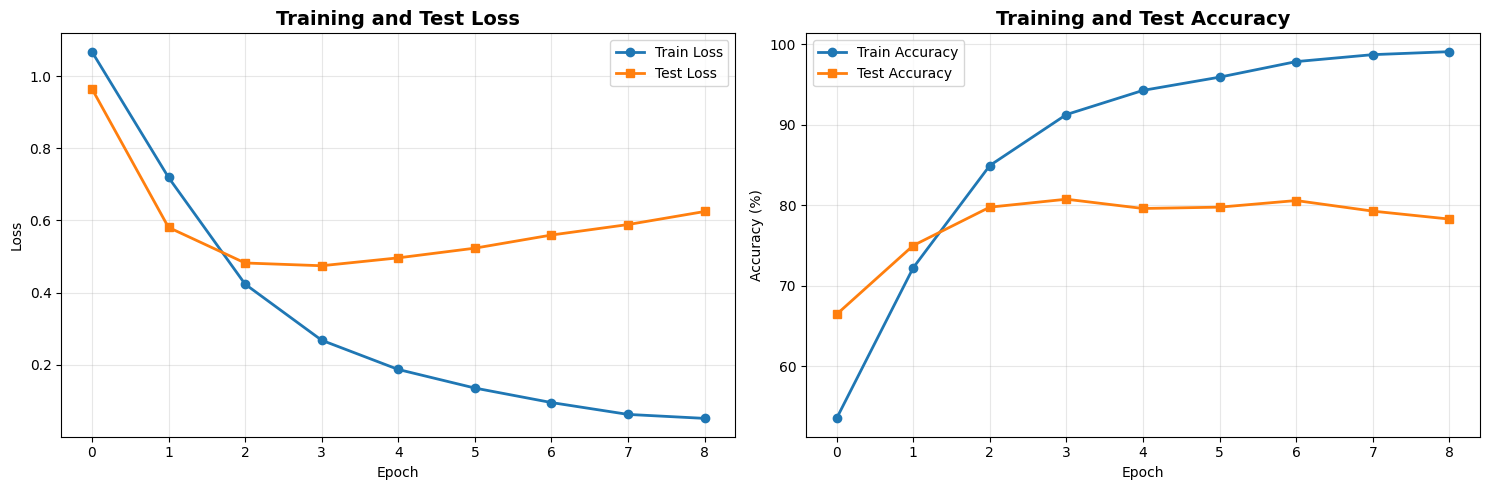


TRAINING SUMMARY
Best test accuracy: 80.76%
Final train accuracy: 99.10%
Final test accuracy: 78.29%
Best epoch: 4
Total parameters: 1,313,539


In [189]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
ax1.plot(test_losses, label='Test Loss', marker='s', linewidth=2)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(test_accuracies, label='Test Accuracy', marker='s', linewidth=2)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training summary
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Best test accuracy: {max(test_accuracies):.2f}%")
print(f"Final train accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")
print(f"Best epoch: {test_accuracies.index(max(test_accuracies)) + 1}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("="*50)